# Inference: Generalised Elliptical Slice Sampling
This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using
Generalised Elliptical Slice Sampling.

First, we create a simple normal distribution.

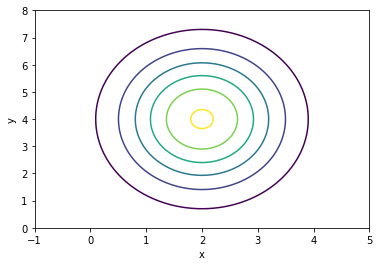

In [2]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceGeneralisedEllipticalMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

#for sampler in mcmc.samplers():

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Generalised Elliptical Slice Sampling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     13      0:00.0
2     20      0:00.0
3     31      0:00.0
1000  8193    0:03.1
2000  16659   0:05.5
3000  25176   0:08.6
4000  33396   0:10.9
5000  41665   0:13.1
6000  49690   0:15.8
7000  57749   0:18.4
8000  65940   0:20.6
9000  74311   0:23.5
10000 82734   0:25.5
Halting: Maximum number of iterations (10000) reached.
Done!


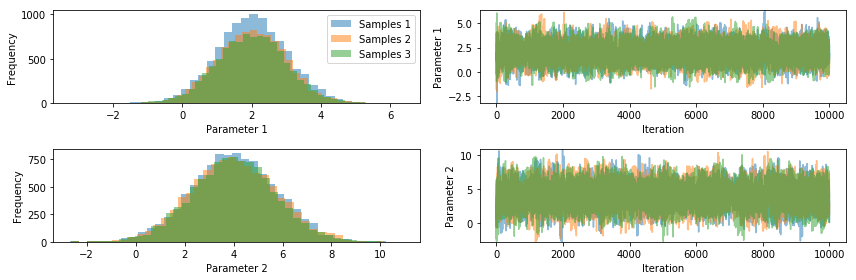

In [4]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[1.0000261327787605, 0.9999655988533882]
0.0013262035354475454
0.0008167558602500957
0.0005682553972612414


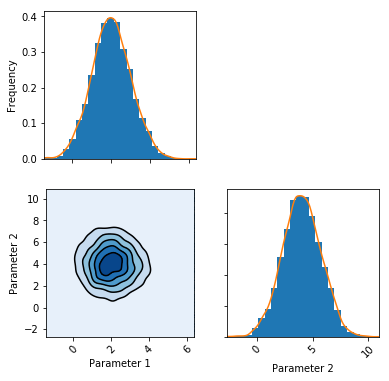

In [5]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

# Generalised Elliptical Slice Sampling on a time-series problem
We now try the same method on a time-series problem

In [8]:
points1 = np.random.uniform(low=0.01, high=0.02, size=19)
points2 = np.random.uniform(low=400, high=600, size=19)
points3 = np.random.uniform(low=1, high=1000, size=19)

starts = np.column_stack((points1, points2, points3))
print(starts)

[[1.57568092e-02 5.31775796e+02 9.09580932e+01]
 [1.06813584e-02 4.56629754e+02 4.34832981e+01]
 [1.13242208e-02 5.69135138e+02 3.67183471e+02]
 [1.56276962e-02 5.52505819e+02 7.87885071e+02]
 [1.65283604e-02 5.84949517e+02 4.92646939e+02]
 [1.50939406e-02 4.66854957e+02 7.29623662e+02]
 [1.07043161e-02 5.50046519e+02 5.86309922e+02]
 [1.25403648e-02 5.75716396e+02 6.18454793e+02]
 [1.61878100e-02 4.87061917e+02 7.50648553e+02]
 [1.40731249e-02 4.05430952e+02 8.76681683e+02]
 [1.15120652e-02 4.82200844e+02 4.43774777e+01]
 [1.45628111e-02 4.68594976e+02 3.77445466e+02]
 [1.70293993e-02 5.21633312e+02 7.41035331e+02]
 [1.43858740e-02 5.63286180e+02 3.95456504e+02]
 [1.27084819e-02 5.77641374e+02 2.48443142e+02]
 [1.75029917e-02 4.79720859e+02 8.68766641e+02]
 [1.83249530e-02 4.30797674e+02 9.78735428e+02]
 [1.40293890e-02 4.05300666e+02 1.84464464e+01]
 [1.82289124e-02 4.00894906e+02 9.83254713e+02]]


In [9]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceGeneralisedEllipticalMCMC)

for i,sampler in enumerate(mcmc.samplers()):
    sampler.give_initial_points(starts)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Generalised Elliptical Slice Sampling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     47      0:00.0
2     84      0:00.0
3     112     0:00.0
1000  33589   0:18.8
2000  64928   0:51.3
3000  99299   1:18.4
4000  132868   1:54.9
5000  167237   2:21.6
6000  201913   2:54.3
7000  237118   3:25.6
8000  272236   3:47.0
9000  306463   4:10.3
10000 340931   4:28.7
Halting: Maximum number of iterations (10000) reached.
Done!


R-hat:
[1.0001614144960838, 1.0012799997589277, 1.0060172639127891]


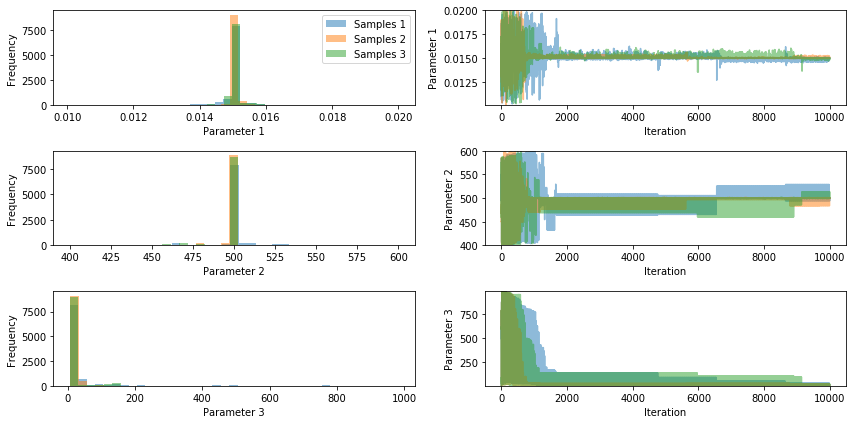

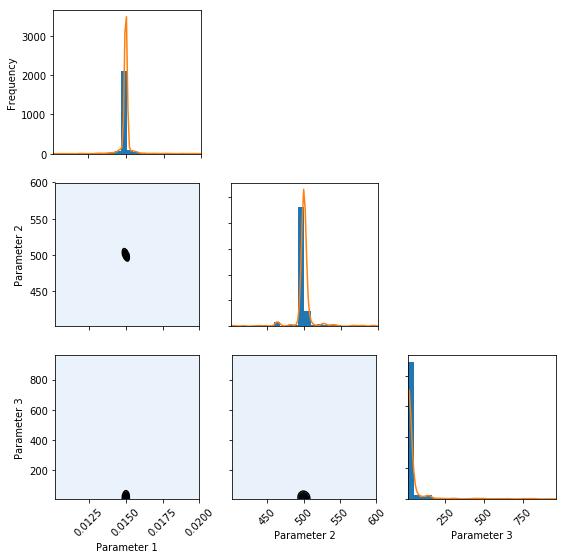

In [10]:
# Show traces and histograms
pints.plot.trace(full_chains)

# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True)

# Show graphs
plt.show()